## Introduction


In following the notebook, I modelled the evaporator by fixing the heat duty (Q) and also fixing inlet/outlet temperatures of the streams, basing my solution on the model of https://oemof.github.io/heat-pump-tutorial/model/tespy-partload-performance.html#tespy-part-load. The picture below shows the setup.



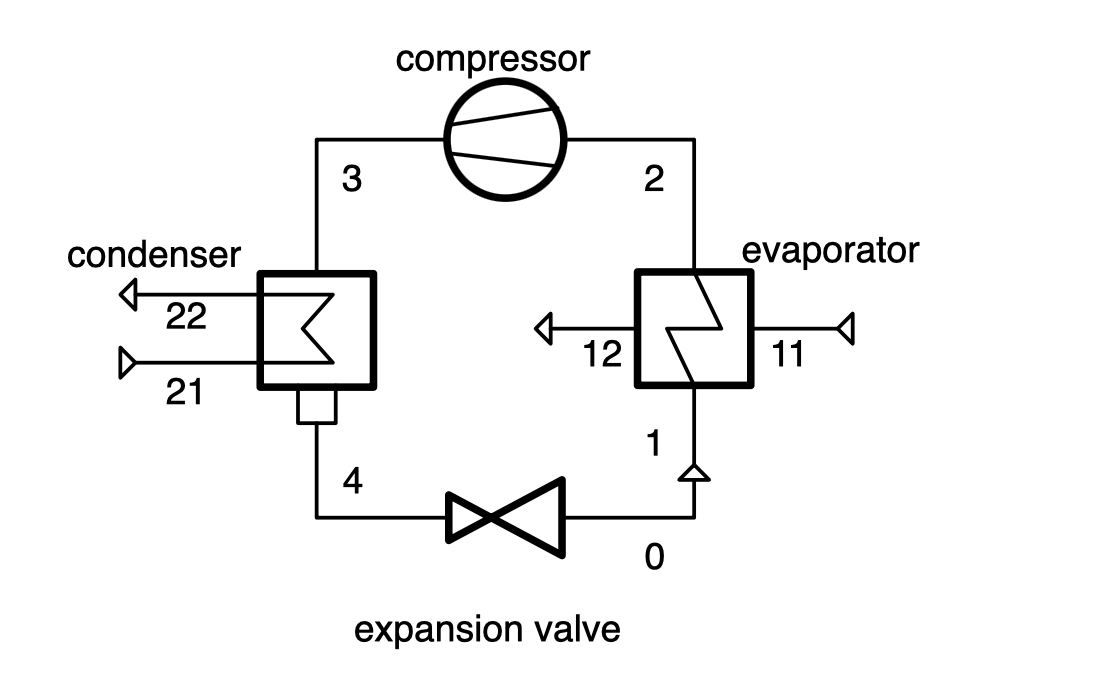

## Design Point Simulation

At the design point, the heat pump is forced to deliver the nominal thermal duties:

- Evaporator: **–1000 kW**
- Condenser: **–1012 kW**
- Compressor efficiency: **ηₛ = 0.85**

Boundary conditions were imposed on the water streams:

| Component       | Inlet T (°C) | Outlet T (°C) |
|-----------------|--------------|----------------|
| **Heat source (evaporator)** | 40 | 10 |
| **Heat sink (condenser)**    | 40 | 90 | 

TESPy solves the refrigerant loop based on energy balances and determines:

- mass flow rate
- pressure ratio (evap vs. cond pressure)
- enthalpies at all state points
- terminal temperature differences (TTDs)
- heat exchanger effectiveness (UA values)

These values are stored in `design_state.json`.  
All **off-design scenarios reference this file** and reuse the same component characteristics.


> **“Solver behaviour and warnings** For a duty of ~500 kW the solver found a physically consistent solution: the terminal temperature differences remained positive and no warnings appeared. However, when I increased the duty to ~1000 kW while keeping the same temperature constraints and flows, TESPy calculated negative terminal differences (ttd_u, ttd_I) and negative effectiveness values, triggering warnings. This occurs because the heat-exchanger has no degree of freedom left to satisfy the higher duty with the given fixed temperatures-the only mathematical way to deliver the heat is to violate the "hot-side always above cold-side" rule (i.e., require negative AT). I also tried alternative topologies (including a drum loop around the evaporator) but still constrained by the fixed-Q and fixed-T paradigm, the warnings persisted.

In [1]:
# 1. Create model
from model import HeatPumpModel

hp_model = HeatPumpModel(working_fluid="ammonia")

# 2. Design point
hp_model.solve_design()


Invalid value for ttd_u: ttd_u = -123.59670066531015 below minimum value (0) at component evaporator.
Invalid value for ttd_l: ttd_l = -82.10142517572689 below minimum value (0) at component evaporator.
Invalid value for ttd_min: ttd_min = -123.59670066531015 below minimum value (0) at component evaporator.
Invalid value for eff_cold: eff_cold = -3.540339183788309 below minimum value (0) at component evaporator.
Invalid value for eff_hot: eff_hot = -0.5749213588506332 below minimum value (0) at component evaporator.
Invalid value for eff_max: eff_max = -0.5749213588506332 below minimum value (0) at component evaporator.



##### RESULTS (Compressor) #####
+------------+----------+----------+-----------+----------+
|            |        P |       pr |        dp |    eta_s |
|------------+----------+----------+-----------+----------|
| compressor | 1.20e+04 | 1.06e+00 | -3.23e+00 | 8.50e-01 |
+------------+----------+----------+-----------+----------+
##### RESULTS (Condenser) #####
+-----------+-----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+------------+-----------+-----------+
|           |         Q |       kA |   td_log |    ttd_u |    ttd_l |   ttd_min |      pr1 |      pr2 |      dp1 |      dp2 |    zeta1 |    zeta2 |   eff_cold |   eff_hot |   eff_max |
|-----------+-----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+------------+-----------+-----------|
| condenser | -1.01e+06 | 4.85e+04 | 2.09e+01 | 5.00e+00 | 5.50e+01 |  5.00e+00

## Part-load operation

Part-load operation refers to when a system is operated below (or above) its originally defined design capacity, so that the actual load differs from the design load. In system modelling (e.g., using TESPy) the design point defines key parameters (mass flows, UA, AT, etc). In part-load simulation one varies the load or ambient/operating conditions while keeping those design parameters fixed, and examines how performance (e.g., COP, effectiveness, terminal temperature differences) changes.

### Overview of Off-Design Scenarios

| Scenario | Modified Parameter(s)      | Description                                                  |
|----------|----------------------------|--------------------------------------------------------------|
| **Baseline (Design)**     | None               | This is the original design point: the heat pump is sized for the nominal duties and temperatures. All component (UA, TTD, efficiencies) characteristics are determined here. |
| **Scenario 1: Temperature variation** | Heat source temperature altered | Only the heat source (water loop) temperature is changed, while design duty and TTDs remain fixed. Because cycle characteristics are frozen, COP and power stay unchanged. |
| **Scenario 2: Combined variation** | Both `Q_evap` and heat-source temperature changed | This is the most realistic off-design case: heating demand drops and ambient/source temperature changes simultaneously. The refrigerant cycle and COP respond accordingly. |

> **Key point:** In the TESPy off-design framework, component characteristics (UA, TTD, efficiency) are held constant after the design point. Therefore, only changes that modify system load (e.g., `Q_evap`) will trigger cycle responses. Changes to inlet/outlet temperatures only affect water side unless the refrigerant loop is freed (via variable UA/TTD).


### Baseline case

In [2]:
hp_model.solve_offdesign(conn="11") 

Invalid value for ttd_u: ttd_u = -123.59670066530987 below minimum value (0) at component evaporator.
Invalid value for ttd_l: ttd_l = -82.10142517572672 below minimum value (0) at component evaporator.
Invalid value for ttd_min: ttd_min = -123.59670066530987 below minimum value (0) at component evaporator.
Invalid value for eff_cold: eff_cold = -3.540339183788309 below minimum value (0) at component evaporator.
Invalid value for eff_hot: eff_hot = -0.5749213588505695 below minimum value (0) at component evaporator.
Invalid value for eff_max: eff_max = -0.5749213588505695 below minimum value (0) at component evaporator.


{'COP': 84.33333333333267,
 'P_comp': 12000.000000000095,
 'Q_evap': -1000000.0,
 'Q_cond': -1012000.0}

### Off-design case 1: Change source temperature (T only)

Here, the inlet temperature of the heat source water (connection 11) was modified,
but **no change to heat duty (`Q_evap`)** was applied.

Results:
- COP did **not** change
- Compressor power did **not** change
- TESPy printed the same warnings as before

**Why nothing changes:**
At off-design, TESPy freezes:
- heat exchanger UA values (from design)
- terminal temperature differences (TTDs)
- refrigerant-side duty (`Q_evap`)

Because `Q` is still fixed, TESPy adjusts only the **outlet water temperature**, not the cycle.

> Changing the heat source temperature alone does not influence the refrigerant circuit, since no degree of freedom is released.

This explains why COP and compressor power remain unchanged.


In [3]:
hp_model.solve_offdesign(conn="11", T_source_in=35)

Invalid value for ttd_u: ttd_u = -128.5967006652814 below minimum value (0) at component evaporator.
Invalid value for ttd_l: ttd_l = -82.10142517572626 below minimum value (0) at component evaporator.
Invalid value for ttd_min: ttd_min = -128.5967006652814 below minimum value (0) at component evaporator.
Invalid value for eff_cold: eff_cold = -3.2745012715944974 below minimum value (0) at component evaporator.
Invalid value for eff_hot: eff_hot = -0.43732685803278254 below minimum value (0) at component evaporator.
Invalid value for eff_max: eff_max = -0.43732685803278254 below minimum value (0) at component evaporator.


{'COP': 84.33333333333267,
 'P_comp': 12000.000000000095,
 'Q_evap': -1000000.0,
 'Q_cond': -1012000.0}

### Off-design case 2: Combined variation (Q + T change)

Here, both:
- evaporator duty (`Q_evap`) was reduced, and
- heat source temperature (connection 11) was changed.

Effects:
- Compressor power changed
- COP changed

This is the only case where both load and operating conditions affect the cycle.


In [4]:
hp_model.solve_offdesign(conn="11", Q_evap=-500000)  # Example off-design conditions

{'COP': 1.9765624999999998,
 'P_comp': 512000.00000000006,
 'Q_evap': -500000.0,
 'Q_cond': -1012000.0}

## Dataset

### Dataset: Load Heat Source & Heat Sink Data

In this section the required variables are extracted from the dataset and then further used for the time-series simulation.

The Excel file contains two sheets:

- **"Heat source"** → inlet & outlet temperatures and mass flow at the evaporator side
- **"Heat sink"** → inlet & outlet temperatures and thermal energy delivered at the condenser side

From each sheet, only the required columns are extracted:
- `T_in[degC]` — inlet temperature
- `T_out[degC]` — outlet temperature
- `P[bar]` — pressure
- `flow[kg/s]` (heat source only)
- `Energy[kWh]` (heat sink only)

These values are then used as boundary conditions for off-design simulations.

In [5]:
import pandas as pd

# 1. Define the correct file path (from src directory to data directory) and sheet name
file_path = '../data/HP_case_data.xlsx'
sheet_name_source = 'Heat source'
sheet_name_sink = 'Heat sink'

# 2. Read the specific sheet into a DataFrame
df_heat_source = pd.read_excel(file_path, sheet_name=sheet_name_source)
df_heat_sink = pd.read_excel(file_path, sheet_name=sheet_name_sink)

# 3. Select the required columns by their exact names
columns_to_extract_source = [
    'T_in[degC',
    'T_out[degC]',
    'P[bar]',
    'flow[kg/s]'
]

df_source_data = df_heat_source[columns_to_extract_source]


columns_to_extract_sink = [
    'T_in[degC',
    'T_out[degC]',
    'P[bar]',
    'Energy[kWh]'
]
df_sink_data = df_heat_sink[columns_to_extract_sink]

# df_source_data now contains only the four specified columns for the Heat source time-series.

### Inspect cleaned dataset

Here I display the newly created DataFrames (`df_source_data` and `df_sink_data`)  
to confirm that:
- column selection was correct,
- no formatting issues exist (unit labels, whitespace).

The values shown below represent the **first timestep** of the time-series.


In [6]:
display(df_source_data)


,T_in[degC,T_out[degC],P[bar],flow[kg/s]
0,56.303558,20,2,2
1,56.272730,20,2,2
2,56.409649,20,2,2
3,56.926243,20,2,2
4,57.631278,20,2,2
...,...,...,...,...
8779,55.025262,20,2,2
8780,54.957070,20,2,2
8781,54.888878,20,2,2
8782,54.820687,20,2,2


In [7]:
display(df_sink_data)

,T_in[degC,T_out[degC],P[bar],Energy[kWh]
0,60,90,2,999.491087
1,60,90,2,997.054953
2,60,90,2,1003.651237
3,60,90,2,1009.563472
4,60,90,2,1011.220805
...,...,...,...,...
8779,60,90,2,1051.578220
8780,60,90,2,1052.112335
8781,60,90,2,1052.646450
8782,60,90,2,1053.180564


### Run full time-series simulation

Here I loop through **all timesteps** from the dataset.
For each timestep:
1. Temperatures, pressures, flows, and condenser energy from the dataset
   are applied as boundary conditions.
2. `model.solve_offdesign()` runs a TESPy off-design simulation.
3. COP, compressor power, Q_evap, and Q_cond are stored.

⚠️ **Note on warnings:**
TESPy warns when temperature differences in heat exchangers (`ttd_u`, `ttd_l`)  
go below zero. This happens when the dataset forces temperature profiles  
that cannot be achieved physically with the fixed Q and temperature constraints.
These warnings are expected in strict off-design or unrealistic boundary conditions.


In [8]:
%%capture
from model import HeatPumpModel          
from run_timeseries import TimeSeriesHeatPumpRunner

model = HeatPumpModel(working_fluid="R134a")
runner = TimeSeriesHeatPumpRunner(model, file_path='../data/HP_case_data.xlsx')

# when ready to run full series:
df_all = runner.run_all()
runner.save_results("hp_offdesign_timeseries.csv")


### Visualize Heat Pump Performance Over Time

Using the extracted results, we plot:
- **COP**
- **Compressor power**
- **Evaporator and condenser heat flows**

This provides a time-evolution of the heat pump performance under varying operating
conditions defined in the dataset.

This step uses the separate visualization class `HeatPumpVisualizer`.


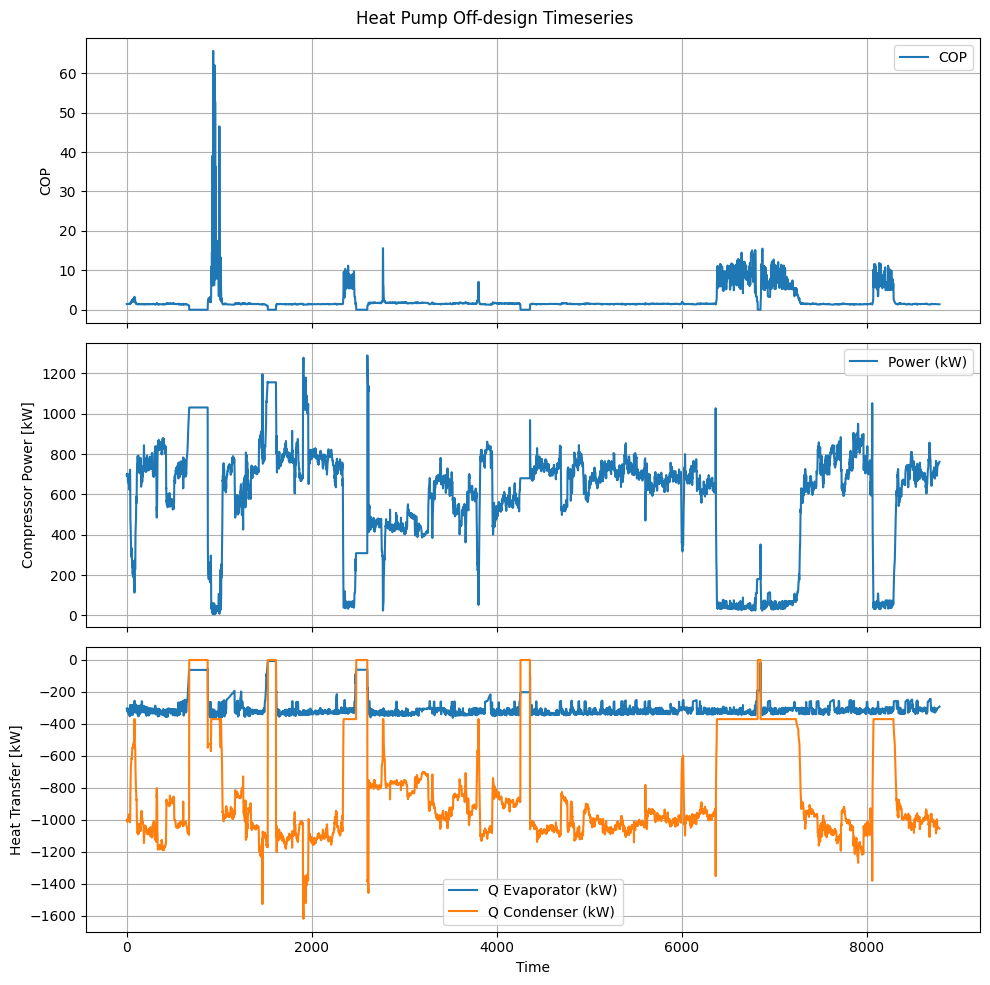

In [9]:
from plots import HeatPumpVisualizer

viz = HeatPumpVisualizer(figsize=(10, 10))
# df_results is the DataFrame you produced via your runner/model
viz.plot_timeseries(df_all, title="Heat Pump Off-design Timeseries")
# Optionally save:
viz.save("hp_timeseries.png")
